## Construccion dataset ##

In [1]:
import pandas as pd
import numpy as np
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from sklearn.metrics.pairwise import linear_kernel
import matplotlib.pyplot as plot
import seaborn as sb

**Recoleccion de datos:** *Para realizar un adecuado analisis, todas las fuentes de informacion deben ser agrupadas(tweets obtenidos mediante hashtags y/o usernames)*

In [2]:
#Para dataset politico solo consideramos tweets obtenidos mediante la busqueda con usernames
df_tweets = pd.read_csv('df_eleccionesLimpio.csv')
print(len(df_tweets))
df_tweets = df_tweets[['id','tweet','username','date','nlikes']]
df_tweets.username.value_counts()

6795


JNE_Peru           926
ONPE_oficial       892
DanielUrresti1     870
Vero_Mendoza_F     747
rlopezaliaga1      526
CesarAcunaP        525
yonhy_lescano      462
PedroCastilloTe    355
MerinoDeLama       344
KeikoFujimori      306
FSagasti           302
HDeSotoPeru        186
MartinVizcarraC    184
George_Forsyth     170
Name: username, dtype: int64

In [ ]:
#Para dataset pandemia consideramos tweets obtenidos mediante la busqueda con usernames y hashtags
df_tweets_1 = pd.read_csv('df_pandemia_hashv2Limpio.csv')
df_tweets_2 = pd.read_csv('DF_pandemiaE.csv')
df_tweets_user = pd.read_csv('df_pandemia_hashLimpio.csv')
df_tweets = pd.concat([df_tweets_1, df_tweets_2, df_tweets_user],ignore_index=False)
#df_tweets = pd.concat([df_tweets_1, df_tweets_user],ignore_index=False)
df_tweets[['id','tweet','username','date','nlikes']].to_csv('df_pand_tweet_C.csv')

In [11]:
def Recuperar_Indice(lista_indices):
    index = []
    for i in lista_indices:
        index.append(i[1])
    index = pd.unique(index)
    index = list(index)
    return index

def Eliminar_Repetidos(df, label, language, threshold):
    print('Analizando ' + str(len(df)) + ' iniciales...')
    tfidf = TfidfVectorizer(stop_words = stopwords.words(language))
    # Construct the TF-IDF matrix
    tfidf_matrix = tfidf.fit_transform(df[label])
    #print(shape(tfidf_matrix))
    # Generate the cosine similarity matrix
    cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)
    #print(cosine_sim)
    #Lista que recupera los tweets
    A = []
    for i in range(0,len(cosine_sim)):
        for k in range(0,len(cosine_sim)):
            if ((k>i) and (cosine_sim[i][k] >= threshold)):
                #print(i,k)
                A.append([i,k])
                
    indices_tweets = Recuperar_Indice(A)
    df = df.drop(indices_tweets)
    #print(df)
    df = df.reset_index(drop = True)
    print('Se han recuperado ' + str(len(df)) + ' tweets')
    return df

# La eliminacion de espacios mediante re nos garantiza que al utilizar **sent_tokenize** no se
# considere espacios de los caracteres especiales como en el caso de los hastags o URLS
import re
def Eliminar_espacios(text):
    pattern = re.compile(r'\s+')
    text = re.sub(pattern, ' ', text)
    text = text.replace(". #","#")
    text = text.replace(" #","#")
    text = text.replace(". @","@")
    text = text.replace(" @","@")
    return text

# Mediante el metodo **obtener_oraciones**, las oraciones que pertenecen a un tweets son desglosadas.
def obtener_oraciones(df):
    new_df = pd.DataFrame()
    dist_sentences = []
    df['tweet_sentence'] = df['tweet_process'].copy()
    count_len = len(df)
    for i, row in df.iterrows():
        #print(i)
        row['tweet_sentence'] = sent_tokenize(row['tweet_process'])
        #row['tweet_sentence'] = row['tweet'].split('.')
        dist_sentences.append(len(row['tweet_sentence']))
        if len(row['tweet_sentence']) > 1:
            #print(len(row['tweet_sentence'])
            for j in row['tweet_sentence']:
                nueva_fila = {'id': row['id'], 'tweet':row['tweet'], 'tweet_sentence': j,'len_sentence': len(row['tweet_sentence']),
                              'username':row['username'], 'date': row['date'],'nlikes':row['nlikes'] } 
                new_df = new_df.append(nueva_fila, ignore_index=True)
        else:
            nueva_fila = {'id': row['id'], 'tweet':row['tweet'], 'tweet_sentence': row['tweet_process'],
                          'len_sentence': len(row['tweet_sentence']), 'username':row['username'], 'date': row['date'],'nlikes':row['nlikes']}
            new_df = new_df.append(nueva_fila, ignore_index=True)
    #new_df['len_sentence'] = df['tweet_sentence'].apply(lambda x: len(x))      
    #new_df.to_excel('tweetS.xlsx')
    return new_df, dist_sentences

#Mediante **verificar_oraciones** eliminamos aquellas oraciones que puden generar ruido en nuestro analisis de acuerdo
# a las condiciones establecidas.
def verificar_oraciones(df):
    indice_eliminados = []
    for i, row in df.iterrows():
        if row['len_word'] < 3:
            indice_eliminados.append(i) 
        #print(type(row['tweet_sentence']), row['tweet_sentence'])
        if row['tweet_sentence'].startswith('https') or row['tweet_sentence'].startswith('(') and row['len_word'] < 4:
            indice_eliminados.append(i)
        
        if 'https' in row['tweet_sentence'] or '(' in row['tweet_sentence'] or 'Vía' in row['tweet_sentence']  and row['len_word'] < 9 :
            indice_eliminados.append(i)
        
        if 'PD' in row['tweet_sentence'] or 'sra' in row['tweet_sentence'] and row['len_word'] < 4:
            indice_eliminados.append(i) 
            
        if bool(re.search(r'\d', row['tweet_sentence'])) and row['len_word'] < 4:
            indice_eliminados.append(i) 
        
        if  'Hola' in row['tweet_sentence'] or 'abrazo' in row['tweet_sentence'] or 'Gracias' in row['tweet_sentence'] or 'dia' in row['tweet_sentence'] or 'Dia' in row['tweet_sentence'] and row['len_word'] < 6 :
            indice_eliminados.append(i)
        
    unique_index = np.unique(indice_eliminados)
    df = df.drop(unique_index) 
    df.reset_index(drop=True, inplace=True)
    
    df = Eliminar_Repetidos(df, 'tweet_sentence', 'spanish', 0.9)
    df.to_csv('tweetS.csv')
    print(len(df))
    return df

In [14]:
df_tweets['tweet_process'] = df_tweets['tweet'].apply(lambda x: Eliminar_espacios(x))
de_sentences, dist_oraciones = obtener_oraciones(df_tweets)
#df_tweets.to_excel('tweets_esp.xlsx')
de_sentences_clean = de_sentences.copy()
#de_sentences_clean.columns

*Utilizamos **word_tokenize** para conocer la distribucion de palabras en cada oracion, ya que las oraciones pueden ser de diferente tamaño. Por otro lado **word_tokenize** y **len_word** para realizar un analisis del contenido de los caracteres de la oracion y poder determinar cuales son las que realmente contiene significado.*

In [15]:
#Atributos necesarios para conocer la distribucion  de praciones por tweets y palabras por oracion. 
de_sentences_clean['tweet_word'] = de_sentences_clean['tweet_sentence'].apply(lambda x: word_tokenize(x))
de_sentences_clean['len_word'] = de_sentences_clean['tweet_word'].apply(lambda x: len(x))
#de_sentences_clean.to_excel('tweetH.xlsx')

In [16]:
de_sentences_clean = verificar_oraciones(de_sentences_clean)
de_sentences_clean

Analizando10665 iniciales...
Se han recuperado 10424 tweets
10424


,id,tweet,tweet_sentence,len_sentence,username,date,nlikes,tweet_word,len_word
0,1.361684e+18,"Por ello, en nuestro Gobierno, sin duda ni mur...","Por ello, en nuestro Gobierno, sin duda ni mur...",4.0,PedroCastilloTe,2021-02-16 09:30:56,46.0,"[Por, ello, ,, en, nuestro, Gobierno, ,, sin, ...",31
1,1.361684e+18,"Por ello, en nuestro Gobierno, sin duda ni mur...",Llegó la hora de cambiar de raíz esté problema.,4.0,PedroCastilloTe,2021-02-16 09:30:56,46.0,"[Llegó, la, hora, de, cambiar, de, raíz, esté,...",10
2,1.361684e+18,"Por ello, en nuestro Gobierno, sin duda ni mur...","Tú y yo, podemos hacerlo.",4.0,PedroCastilloTe,2021-02-16 09:30:56,46.0,"[Tú, y, yo, ,, podemos, hacerlo, .]",7
3,1.361684e+18,"Por ello, en nuestro Gobierno, sin duda ni mur...",Palabra de Maestro,4.0,PedroCastilloTe,2021-02-16 09:30:56,46.0,"[Palabra, de, Maestro]",3
4,1.361684e+18,Políticos como Vizcarra y su «gente de confian...,Políticos como Vizcarra y su «gente de confian...,5.0,PedroCastilloTe,2021-02-16 09:29:20,48.0,"[Políticos, como, Vizcarra, y, su, «, gente, d...",29
...,...,...,...,...,...,...,...,...,...
10419,1.554257e+18,#JNEFactChecking | Falso. En ninguna parte de ...,En ninguna parte de la entrevista se habla de ...,3.0,JNE_Peru,2022-08-01 19:04:10,128.0,"[En, ninguna, parte, de, la, entrevista, se, h...",16
10420,1.554257e+18,#JNEFactChecking | Falso. Zamir Villaverde no ...,"Zamir Villaverde no ha ""confirmado"" tener un a...",3.0,JNE_Peru,2022-08-01 19:04:08,529.0,"[Zamir, Villaverde, no, ha, ``, confirmado, ''...",18
10421,1.554230e+18,La Resolución precisa que una eventual declara...,La Resolución precisa que una eventual declara...,1.0,JNE_Peru,2022-08-01 17:18:49,3.0,"[La, Resolución, precisa, que, una, eventual, ...",37
10422,1.554230e+18,El Pleno del JNE ha declarado nulo el fallo em...,El Pleno del JNE ha declarado nulo el fallo em...,2.0,JNE_Peru,2022-08-01 17:18:49,3.0,"[El, Pleno, del, JNE, ha, declarado, nulo, el,...",42


## Distribucion de datos ##
Construimos graficos de distribucion de oraciones en cada tweeet, asi como la distribucion de palabras por oracion.

In [19]:
def grafico_distribucion(lista, xlabel, name, rango):
    intervalos = range(min(lista), max(lista) + rango) #calculamos los extremos de los intervalos
    plot.figure(figsize=(20, 6))
    plot.hist(x=lista, bins=intervalos, color='#F2AB6D', rwidth=0.85)
    #plot.title('Histograma de edades - matplotlib - codigopiton.com')
    
    plot.xlabel(xlabel)
    plot.ylabel('Frecuencia')
    #plot.xticks(intervalos)
    plot.savefig(name)
    plot.show() #dibujamos el histograma
#grafico_distribucion(dist_oraciones, 'Oraciones','dist_ora.eps', 2)
# copy the data
def normalizar_columna(df, column):
    df_min_max_scaled = df.copy()
    # apply normalization techniques by Column 1
    #column = 'Column 1'
    df_min_max_scaled[column] = df_min_max_scaled[column] - df_min_max_scaled[column].min() / df_min_max_scaled[column].max() - df_min_max_scaled[column].min()    
    return df_min_max_scaled

def plot_hist(df, columna, name):
    plot.figure(figsize=(10, 8))
    histogram = df_plot[columna].plot.hist()
    #print(histogram)
    #plot.xlabel()
    plot.ylabel('Frecuencia', size=22)
    plot.xticks(size = 20)
    plot.yticks(size = 20)
    plot.savefig(name)
    plot.show()

#plot_hist(df_plot, 'len_word', 'hist_pol_word.pdf')

In [20]:
de_sentences_clean['len_sentence'] = de_sentences_clean['len_sentence'].astype(int)
de_sentences_clean['nlikes'] = de_sentences_clean['nlikes'].astype(int)
de_sentences_clean.info()
#print(de_sentences_clean)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10424 entries, 0 to 10423
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              10424 non-null  float64
 1   tweet           10424 non-null  object 
 2   tweet_sentence  10424 non-null  object 
 3   len_sentence    10424 non-null  int32  
 4   username        10424 non-null  object 
 5   date            10424 non-null  object 
 6   nlikes          10424 non-null  int32  
 7   tweet_word      10424 non-null  object 
 8   len_word        10424 non-null  int64  
dtypes: float64(1), int32(2), int64(1), object(5)
memory usage: 651.6+ KB


In [ ]:
# view normalized data
df_plot = normalizar_columna(de_sentences_clean,'len_sentence')

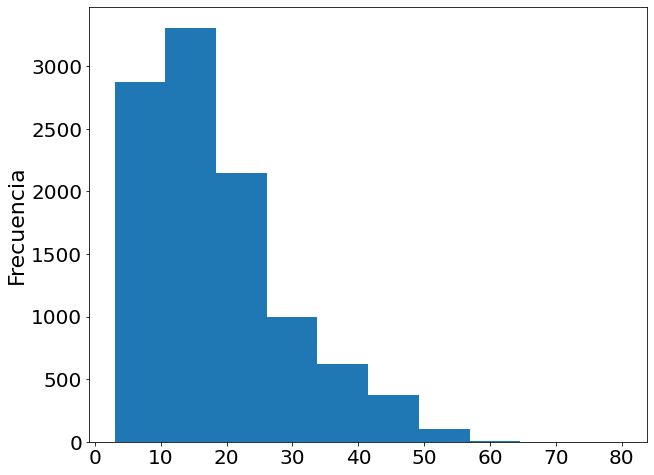

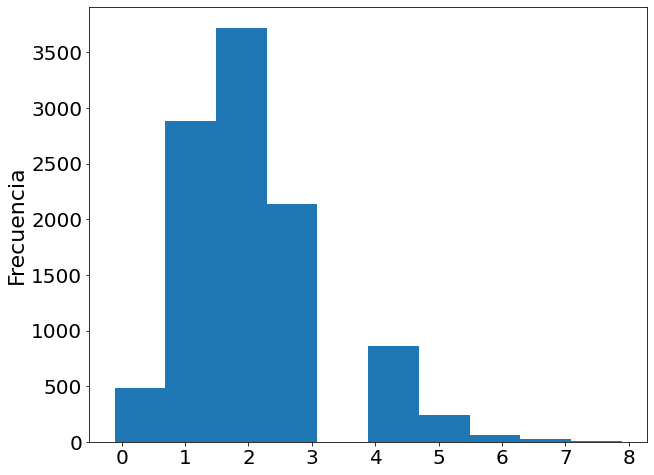

In [15]:
plot_hist(df_plot, 'len_word', 'hist_pol_word.pdf')
plot_hist(df_plot, 'len_sentence', 'hist_pol_sentence.pdf')

In [816]:
from scipy import stats
def normalidad_variable_numerica(columna, name):
    plt.figure(figsize=(10, 6))
    stats.probplot(columna, plot=plt)
    #plt.xlabel('Diagrama de Probabilidad(normal) de la variable {}'.format(columna))
    plt.savefig(name)
    plt.show()

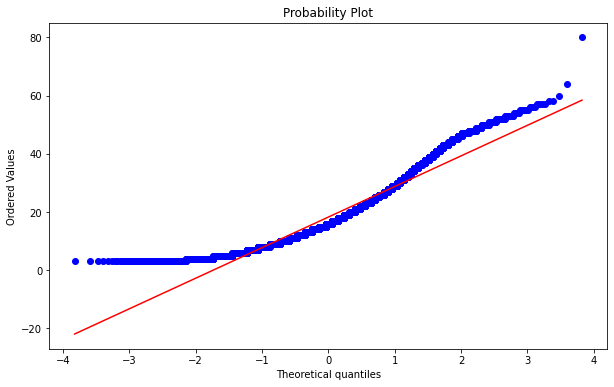

In [817]:
normalidad_variable_numerica(de_sentences_clean['len_word'].to_list(),'dist_normalidad.eps')